In [1]:
from fastai.vision import *

In [3]:
path = Path("data")
tfms = get_transforms(do_flip=True, flip_vert=True)
path.ls()

[WindowsPath('data/test'),
 WindowsPath('data/train'),
 WindowsPath('data/valid')]

In [8]:
data =(ImageList.from_folder(path)
      .split_by_folder()
      .label_from_folder()
      .transform(tfms, size=100)
      .databunch(bs=8))

In [9]:
data.train_ds[0]

(Image (3, 100, 100), Category animal)

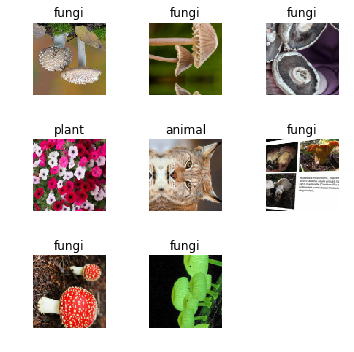

In [10]:
data.show_batch(rows=3, figsize=(5,5))

In [11]:
arch = models.resnet34
learn = cnn_learner(data, arch)
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,time
0,1.065477,0.440507,01:34
1,0.870002,0.414896,01:34
2,0.701792,0.365715,01:35
3,0.603924,0.328740,01:34
4,0.562663,0.306292,01:34
